# CLAHE 적용 LAB, 3채널따로 적용 차이

In [2]:
import cv2

def crop_and_resize_image(image, img_size, use_3channel=False, use_LAB=False):
    '''
    각 채널을 받아 크기 조정(512x512 픽셀로 다운샘플링), 
    이미지 크롭 수행(FOV의 직경과 동일한 정사각형),
    각 채널 합치기
    
    img_size=(512, 512)
    '''
    # 3개의 채널 전부 전처리할 경우
    if use_3channel:
        if use_LAB:
            cropped_image = cv2.resize(image, img_size, interpolation=cv2.INTER_CUBIC)
        
        else:
            channels = [cv2.resize(image[:, :, i], img_size) for i in range(3)]
            diameter = min(channels[0].shape[0], channels[0].shape[1])
            center_x, center_y = channels[0].shape[1] // 2, channels[0].shape[0] // 2
            crop_size = min(center_x, center_y, diameter // 2)
            cropped_channels = [channel[center_y - crop_size:center_y + crop_size, center_x - crop_size:center_x + crop_size] for channel in channels]
            cropped_image = cv2.merge(cropped_channels)
    
    # 녹색 채널만 전처리할 경우
    else:
        resized_image = cv2.resize(image, img_size)
        diameter = min(resized_image.shape[0], resized_image.shape[1])
        center_x, center_y = resized_image.shape[1] // 2, resized_image.shape[0] // 2
        crop_size = min(center_x, center_y, diameter // 2)
        cropped_image = resized_image[center_y - crop_size:center_y + crop_size, center_x - crop_size:center_x + crop_size]
        
    return cropped_image

def apply_clahe(image, clahe):
    # LAB 색 공간으로 변환
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    
    # 각 채널에 CLAHE 적용
    lab_image[:, :, 0] = clahe.apply(lab_image[:, :, 0])
    
    # BGR 색 공간으로 다시 변환
    enhanced_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2BGR)
    return enhanced_image

def preprocess_image(image_path, img_size=(512, 512), use_hist=True, use_3channel=False, use_LAB=False, CLAHE_args=None):
    '''
    image_path를 받아 이미지를 읽고, 
    각 채널에 대한 대비 향상, 
    크롭 및 크기 조정
    '''
    
    if CLAHE_args != None:
        clipLimit, tileGridSize = CLAHE_args
    
    original_image = cv2.imread(image_path)

    if use_3channel:
        # 모든 채널 가져오기
        channels = [original_image[:, :, i] for i in range(3)]

        # 대비 향상 적용
        if use_hist:
            if use_LAB:
                # 대비 향상 적용
                clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
                contrast_enhanced_image = apply_clahe(original_image, clahe)

                # 크롭 및 크기 조정
                cropped_image = crop_and_resize_image(contrast_enhanced_image, img_size, use_3channel=True)
            
            else:
                clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
                contrast_enhanced_channels = [clahe.apply(channel) for channel in channels]

                # 각 채널 합치기
                contrast_enhanced_image = cv2.merge(contrast_enhanced_channels)
                cropped_image = crop_and_resize_image(contrast_enhanced_image, img_size, use_3channel=True)
                
        else:
            # 각 채널 합치기
            cropped_image = crop_and_resize_image(original_image, img_size, use_3channel=True)
    else:
        # 녹색 채널만 사용
        green_channel = original_image[:, :, 1]

        # 대비 향상 적용
        if use_hist:
            clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
            contrast_enhanced_image = clahe.apply(green_channel)
            cropped_image = crop_and_resize_image(contrast_enhanced_image, img_size, use_3channel=False)
        else:
            cropped_image = crop_and_resize_image(green_channel, img_size, use_3channel=False)

    # 0~1로 scale 맞추기
    cropped_image = cropped_image / 255.0
      
    return cropped_image


In [3]:
def visualize_images(image_paths, titles):
    num_images = len(image_paths)
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(image_paths[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

## RGB 3채널, 1채널, LAB 3채널 시각화

NonLAB_3channel time : 0.0579 seconds
NonLAB_1channel time : 0.0415 seconds
LAB_3channel time : 0.0668 seconds
Histogram Equalization time : 0.0031 seconds
Histogram Equalization time : 0.0219 seconds


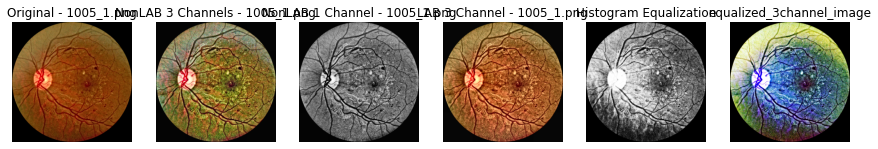

NonLAB_3channel time : 0.0595 seconds
NonLAB_1channel time : 0.0399 seconds
LAB_3channel time : 0.0658 seconds
Histogram Equalization time : 0.0042 seconds
Histogram Equalization time : 0.0227 seconds


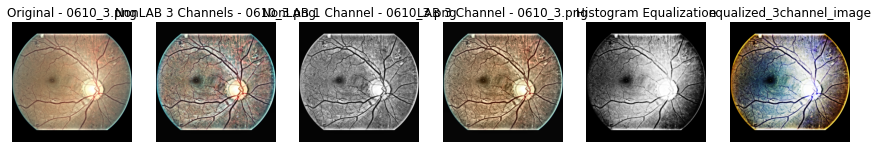

NonLAB_3channel time : 0.0622 seconds
NonLAB_1channel time : 0.0514 seconds
LAB_3channel time : 0.0678 seconds
Histogram Equalization time : 0.0030 seconds
Histogram Equalization time : 0.0217 seconds


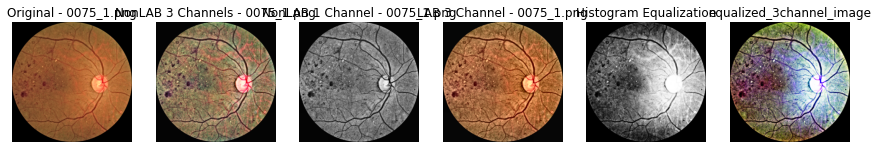

NonLAB_3channel time : 0.0619 seconds
NonLAB_1channel time : 0.0427 seconds
LAB_3channel time : 0.0662 seconds
Histogram Equalization time : 0.0064 seconds
Histogram Equalization time : 0.0216 seconds


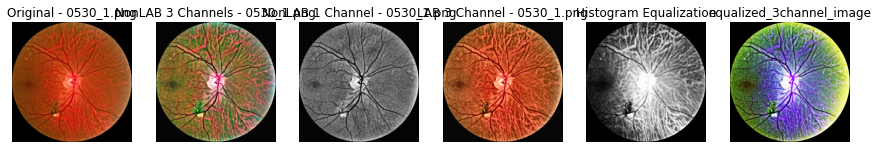

NonLAB_3channel time : 0.0821 seconds
NonLAB_1channel time : 0.0587 seconds
LAB_3channel time : 0.0786 seconds
Histogram Equalization time : 0.0030 seconds
Histogram Equalization time : 0.0204 seconds


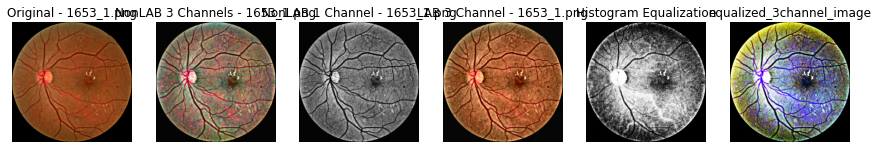

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import time
import random

# 이미지 폴더 경로 지정
image_folder_path = r"../data/FGADR/Seg-set/Original_Images"

# 폴더 내의 이미지 파일 리스트 가져오기
image_files = os.listdir(image_folder_path)

# 5개의 이미지를 랜덤하게 선택
random_image_files = random.sample(image_files, 5)

# 선택된 이미지를 순회하며 표시
for filename in random_image_files:
    # 이미지 파일 경로 생성
    image_path = os.path.join(image_folder_path, filename)

    # 원본 이미지 읽기
    original_image = cv2.imread(image_path)[:, :, ::-1]  # OpenCV는 BGR, Matplotlib은 RGB 순서
    
    start_time = time.time()

    # 3채널 전처리된 이미지 얻기
    NonLAB_3channel = preprocess_image(image_path, img_size=(512, 512), use_hist=True, use_3channel=True, use_LAB=False, CLAHE_args=[3.0, (8, 8)])

    # uint8로 변환
    NonLAB_3channel = (NonLAB_3channel * 255).astype(np.uint8)
    
    # 이미지를 BGR에서 RGB로 변환
    NonLAB_3channel = cv2.cvtColor(NonLAB_3channel, cv2.COLOR_BGR2RGB)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"NonLAB_3channel time : {elapsed_time:.4f} seconds")
    
    start_time = time.time()

    # 1채널 전처리된 이미지 얻기
    NonLAB_1channel = preprocess_image(image_path, img_size=(512, 512), use_hist=True, use_3channel=False, use_LAB=False, CLAHE_args=[3.0, (8, 8)])
    
    NonLAB_1channel = (NonLAB_1channel * 255).astype(np.uint8)
    
    NonLAB_1channel = cv2.cvtColor(NonLAB_1channel, cv2.COLOR_BGR2RGB)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"NonLAB_1channel time : {elapsed_time:.4f} seconds")
    
    start_time = time.time()
    
    LAB_3channel = preprocess_image(image_path, img_size=(512, 512), use_hist=True, use_3channel=True, use_LAB=True, CLAHE_args=[3.0, (8, 8)])
    
    LAB_3channel = (LAB_3channel * 255).astype(np.uint8)
    
    LAB_3channel = cv2.cvtColor(LAB_3channel, cv2.COLOR_BGR2RGB)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"LAB_3channel time : {elapsed_time:.4f} seconds")
    
    # equalizeHist을 사용해서 1채널 히스토그램 평활화 수행
    start_time = time.time()
    equalized_image = cv2.equalizeHist(original_image[:, :, 0])  # 1채널만 사용
    equalized_image = cv2.merge([equalized_image, equalized_image, equalized_image])  # 1채널을 3채널로 확장
    equalized_image = cv2.cvtColor(equalized_image, cv2.COLOR_BGR2RGB)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Histogram Equalization time : {elapsed_time:.4f} seconds")
    
    
    # equalizeHist를 사용해서 3채널 히스토그램 평활화 수행
    start_time = time.time()
    equalized_3channel_image = original_image.copy()
    for i in range(3):  # 각 채널에 대해 히스토그램 평활화 수행
        equalized_3channel_image[:, :, i] = cv2.equalizeHist(equalized_3channel_image[:, :, i])
    equalized_3channel_image = cv2.cvtColor(equalized_3channel_image, cv2.COLOR_BGR2RGB)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Histogram Equalization time : {elapsed_time:.4f} seconds")

    # 이미지 파일명 가져오기
    _, filename = os.path.split(image_path)
    
    image_list = [original_image, NonLAB_3channel, NonLAB_1channel, LAB_3channel, equalized_image, equalized_3channel_image]
    title_list = [f'Original - {filename}', f'NonLAB 3 Channels - {filename}', f'NonLAB 1 Channel - {filename}',
                  f'LAB 3 Channel - {filename}', 'Histogram Equalization', 'equalized_3channel_image']
    
    visualize_images(image_list, title_list)
    print("=========================================================================================================================")


## CLAHE 인자 결과별 시각화

In [11]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random

def preprocess_and_visualize(image_folder_path, CLAHE_values, num_images=5):
    # 폴더 내의 이미지 파일 리스트 가져오기
    image_files = os.listdir(image_folder_path)

    # 랜덤하게 이미지를 선택
    random_image_files = random.sample(image_files, num_images)

    # 선택된 이미지를 순회하며 표시
    for filename in random_image_files:
        # 이미지 파일 경로 생성
        image_path = os.path.join(image_folder_path, filename)

        # 원본 이미지 읽기
        original_image = cv2.imread(image_path)[:, :, ::-1]  # OpenCV는 BGR, Matplotlib은 RGB 순서

        # CLAHE 인자에 따라 전처리된 이미지 생성
        NonLAB_images = []
        LAB_images = []
        NonLAB_titles = []
        LAB_titles = []
        
        NonLAB_images.append(original_image)
        NonLAB_titles.append(f'original\n - {filename}')
        
        LAB_images.append(original_image)
        LAB_titles.append(f'original\n - {filename}')
        
        for tileGridSize in CLAHE_values:
            # Non-LAB
            NonLAB_3channel = preprocess_image(image_path, img_size=(512, 512), use_hist=True, use_3channel=True, 
                                           use_LAB=False, CLAHE_args=[3.0, tileGridSize])
            NonLAB_3channel = (NonLAB_3channel * 255).astype(np.uint8)
            NonLAB_3channel = cv2.cvtColor(NonLAB_3channel, cv2.COLOR_BGR2RGB)
            NonLAB_images.append(NonLAB_3channel)
            NonLAB_titles.append(f'NonLAB arg{tileGridSize}\n - {filename}')

            # LAB
            LAB_3channel = preprocess_image(image_path, img_size=(512, 512), use_hist=True, use_3channel=True, 
                                        use_LAB=True, CLAHE_args=[3.0, tileGridSize])
            LAB_3channel = (LAB_3channel * 255).astype(np.uint8)
            LAB_3channel = cv2.cvtColor(LAB_3channel, cv2.COLOR_BGR2RGB)
            LAB_images.append(LAB_3channel)
            LAB_titles.append(f'LAB arg{tileGridSize}\n - {filename}')

        visualize_images(NonLAB_images, NonLAB_titles)
        visualize_images(LAB_images, LAB_titles)
        print("===========================================================================================================================")

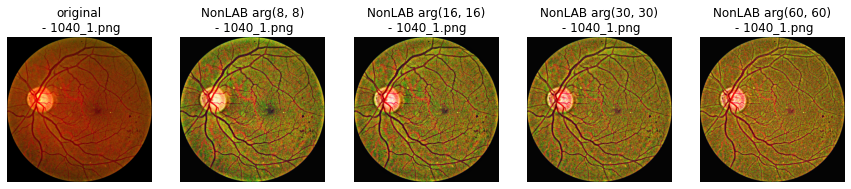

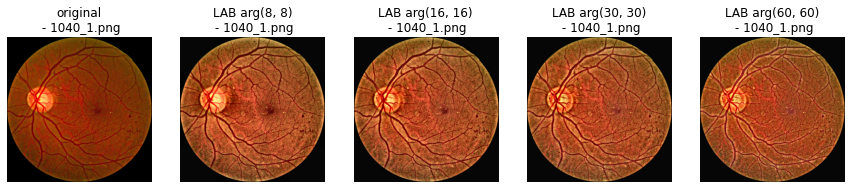

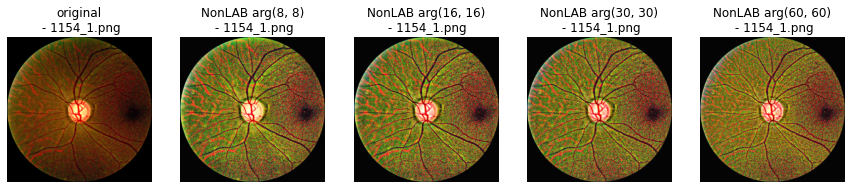

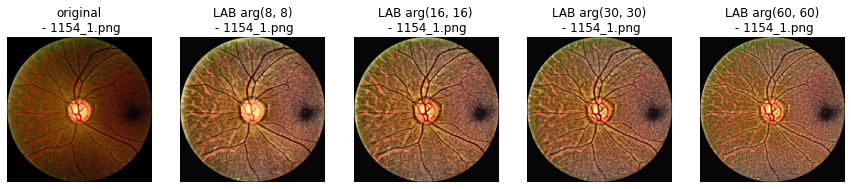

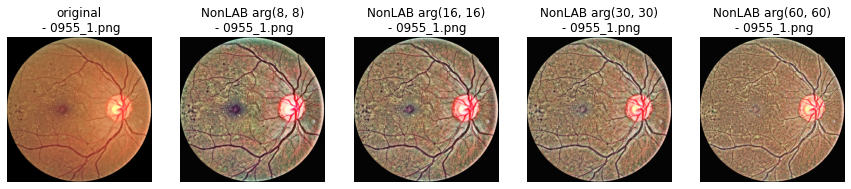

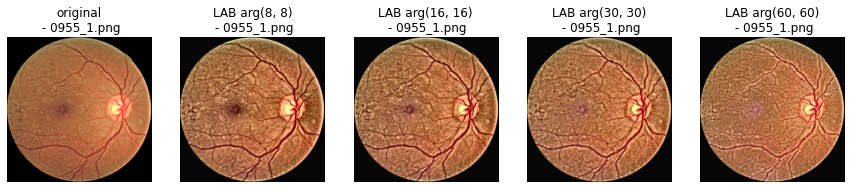

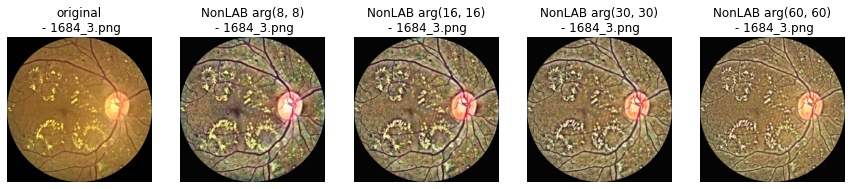

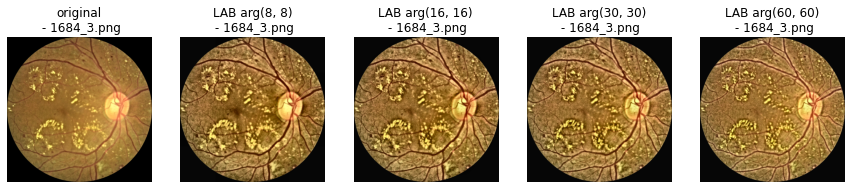

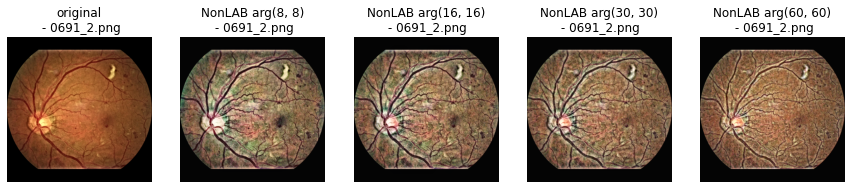

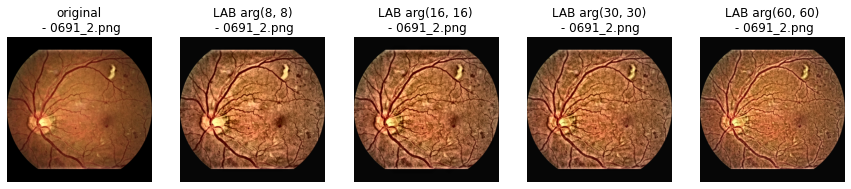

In [13]:
# 이미지 폴더 경로 지정
image_folder_path = r"../data/FGADR/Seg-set/Original_Images"

CLAHE_values = [(8, 8), (16, 16), (30, 30), (60, 60)]

# 이미지 전처리 및 시각화
preprocess_and_visualize(image_folder_path, CLAHE_values)

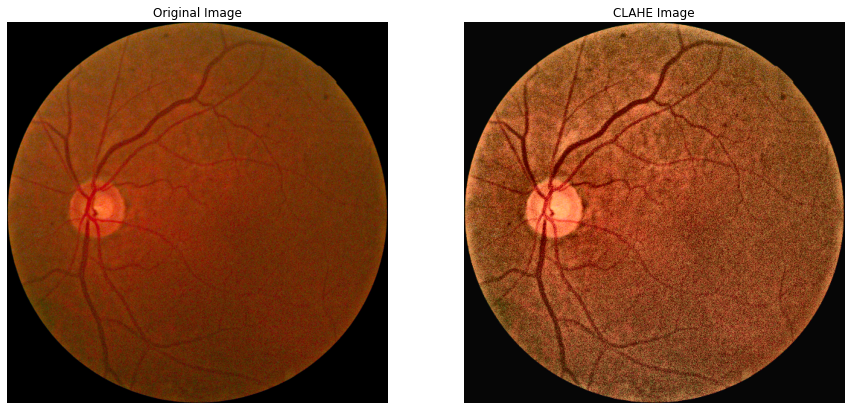

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 컬러 이미지 읽기
image_path = r"../data/FGADR/Seg-set/Original_Images/0106_1.png"
original_image = cv2.imread(image_path)

# 이미지를 BGR에서 RGB로 변환하여 표시
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# 컬러 이미지를 각 채널로 분리
b, g, r = cv2.split(original_image)

# 각 채널에 대해 히스토그램 평활화 적용
b_equalized = cv2.equalizeHist(b)
g_equalized = cv2.equalizeHist(g)
r_equalized = cv2.equalizeHist(r)

# 평활화된 채널을 합쳐서 컬러 이미지 생성
equalized_image = cv2.merge((b_equalized, g_equalized, r_equalized))
equalized_image_rgb = cv2.cvtColor(equalized_image, cv2.COLOR_BGR2RGB)

NonLAB_3channel = preprocess_image(image_path, img_size=(512, 512), use_hist=True, use_3channel=True, 
                               use_LAB=False, CLAHE_args=[3.0, (8, 8)])
NonLAB_3channel = (NonLAB_3channel * 255).astype(np.uint8)
NonLAB_3channel = cv2.cvtColor(NonLAB_3channel, cv2.COLOR_BGR2RGB)

LAB_3channel = preprocess_image(image_path, img_size=(512, 512), use_hist=True, use_3channel=True, 
                            use_LAB=True, CLAHE_args=[3.0, (8, 8)])
LAB_3channel = (LAB_3channel * 255).astype(np.uint8)
LAB_3channel = cv2.cvtColor(LAB_3channel, cv2.COLOR_BGR2RGB)

# 원본 이미지와 평활화된 이미지를 양옆으로 나란히 표시
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image')
plt.axis('off')

# plt.subplot(1, 4, 2)
# plt.imshow(equalized_image_rgb)
# plt.title('Equalized Image')
# plt.axis('off')

# plt.subplot(1, 4, 3)
# plt.imshow(NonLAB_3channel)
# plt.title('NonLAB_3channel Image')
# plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(LAB_3channel)
plt.title('CLAHE Image')
plt.axis('off')

plt.show()


In [ ]:
import cv2
import matplotlib.pyplot as plt

def plot_image_and_histogram(image, title):
    # 히스토그램 계산
    hist, bins = np.histogram(image.flatten(), bins=256, range=[0, 256])

    # 이미지 및 히스토그램 막대그래프 플로팅
    plt.figure(figsize=(15, 6))
    
    plt.subplot(2, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'{title}')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.bar(range(256), hist, color='black', alpha=0.5)
    plt.title(f'{title} - 히스토그램')
    plt.xlabel('픽셀 강도')
    plt.ylabel('해당하는 픽셀 빈도수')

    plt.show()

# 이미지 경로
image_path = r"../data/FGADR/Seg-set/Original_Images/0002_1.png"

# 원본 이미지 읽기
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 전처리된 이미지 얻기
preprocessed_image = preprocess_image(image_path, img_size=(512, 512), use_hist=True, use_3channel=True)
# uint8로 변환
preprocessed_image = (preprocessed_image * 255).astype(np.uint8)

# 이미지를 BGR에서 RGB로 변환
preprocessed_image = cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2RGB)

# 원본 이미지와 전처리된 이미지, 각각의 히스토그램 분포 플로팅
plot_image_and_histogram(original_image, '원본 이미지')
plot_image_and_histogram(preprocessed_image, '전처리된 이미지')


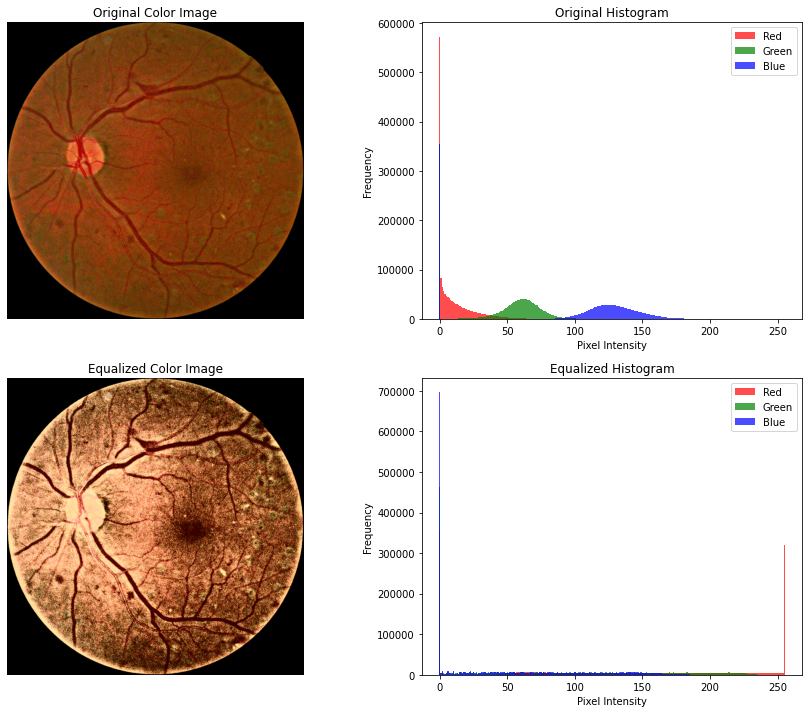

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def histogram_equal(image):
    # Color image
    if len(image.shape) == 3:
        lab_array = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab_array)
        equalized_l = cv2.equalizeHist(l)
        merged_array = cv2.merge([equalized_l, a, b])
        output = cv2.cvtColor(merged_array, cv2.COLOR_LAB2RGB)
    # Gray image
    else:
        output = cv2.equalizeHist(image)
    return output

# 이미지 경로
image_path = r"../data/FGADR/Seg-set/Original_Images/1001_1.png"

# 컬러 이미지로 읽기
image_color = cv2.imread(image_path, cv2.IMREAD_COLOR)

equalized_image = histogram_equal(image_color)

# 각 채널에 대해 히스토그램 계산
hist_original_channels = [np.histogram(channel.flatten(), bins=256, range=[0, 256]) for channel in cv2.split(image_color)]
hist_equalized_channels = [np.histogram(channel.flatten(), bins=256, range=[0, 256]) for channel in cv2.split(equalized_image)]

# 시각화
plt.figure(figsize=(15, 12))

# 원본 이미지와 히스토그램 플로팅
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.title('Original Color Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.bar(range(256), hist_original_channels[0][0], color='red', alpha=0.7, width=1, label='Red')
plt.bar(range(256), hist_original_channels[1][0], color='green', alpha=0.7, width=1, label='Green')
plt.bar(range(256), hist_original_channels[2][0], color='blue', alpha=0.7, width=1, label='Blue')
plt.title('Original Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()

# 균등화된 이미지와 히스토그램 플로팅
plt.subplot(2, 2, 3)
plt.imshow(equalized_image)
plt.title('Equalized Color Image')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.bar(range(256), hist_equalized_channels[0][0], color='red', alpha=0.7, width=1, label='Red')
plt.bar(range(256), hist_equalized_channels[1][0], color='green', alpha=0.7, width=1, label='Green')
plt.bar(range(256), hist_equalized_channels[2][0], color='blue', alpha=0.7, width=1, label='Blue')
plt.title('Equalized Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()

plt.show()


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 이미지 경로
image_path = r"D:\VS_Code\DN_project\DR-GeuAl\data\FGADR\Seg-set\Original_Images\0000_1.png"

# 컬러 이미지로 읽기
image_color = cv2.imread(image_path, cv2.IMREAD_COLOR)

# 그레이스케일 이미지로 변환
image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

# 녹색 채널 추출
green_channel = image_color[:, :, 1]

# CLAHE 알고리즘 적용
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
clahe_color = cv2.merge([clahe.apply(channel) for channel in cv2.split(image_color)])
clahe_green = clahe.apply(green_channel)
clahe_gray = clahe.apply(image_gray)

# 히스토그램 계산
hist_color, bins_color = np.histogram(image_color.flatten(), bins=256, range=[0, 256])
hist_green, bins_green = np.histogram(green_channel.flatten(), bins=256, range=[0, 256])
hist_clahe_color, bins_clahe_color = np.histogram(clahe_color.flatten(), bins=256, range=[0, 256])
hist_clahe_green, bins_clahe_green = np.histogram(clahe_green.flatten(), bins=256, range=[0, 256])
hist_gray, bins_gray = np.histogram(image_gray.flatten(), bins=256, range=[0, 256])
hist_clahe_gray, bins_clahe_gray = np.histogram(clahe_gray.flatten(), bins=256, range=[0, 256])

# 시각화
plt.figure(figsize=(18, 18))

# 원본 컬러 이미지 및 히스토그램
plt.subplot(4, 3, 1)
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.title('원본 컬러 이미지')
plt.axis('off')

plt.subplot(4, 3, 4)
plt.bar(range(256), hist_color, color='black', width=1)
plt.title('원본 컬러 히스토그램')
plt.xlabel('픽셀 강도')
plt.ylabel('빈도')
plt.ylim(top=400000)

# CLAHE 적용된 컬러 이미지 및 히스토그램
plt.subplot(4, 3, 2)
plt.imshow(cv2.cvtColor(clahe_color, cv2.COLOR_BGR2RGB))
plt.title('CLAHE 적용된 컬러 이미지')
plt.axis('off')

plt.subplot(4, 3, 5)
plt.bar(range(256), hist_clahe_color, color='black', width=1)
plt.title('CLAHE 컬러 히스토그램')
plt.xlabel('픽셀 강도')
plt.ylabel('빈도')
plt.ylim(top=400000)

# 원본 녹색 채널 이미지 및 히스토그램
plt.subplot(4, 3, 7)
plt.imshow(green_channel, cmap='gray')
plt.title('원본 녹색 채널 이미지')
plt.axis('off')

plt.subplot(4, 3, 10)
plt.bar(range(256), hist_green, color='green', width=1)
plt.title('원본 녹색 채널 히스토그램')
plt.xlabel('픽셀 강도')
plt.ylabel('빈도')
plt.ylim(top=400000)

# CLAHE 적용된 녹색 채널 이미지 및 히스토그램
plt.subplot(4, 3, 8)
plt.imshow(clahe_green, cmap='gray', vmin=0, vmax=255)
plt.title('CLAHE 적용된 녹색 채널')
plt.axis('off')

plt.subplot(4, 3, 11)
plt.bar(range(256), hist_clahe_green, color='green', width=1)
plt.title('CLAHE 녹색 채널 히스토그램')
plt.xlabel('픽셀 강도')
plt.ylabel('빈도')
plt.ylim(top=400000)

# 원본 그레이스케일 이미지 및 히스토그램
plt.subplot(4, 3, 3)
plt.imshow(image_gray, cmap='gray')
plt.title('원본 그레이스케일 이미지')
plt.axis('off')

plt.subplot(4, 3, 6)
plt.bar(range(256), hist_gray, color='black', width=1)
plt.title('원본 그레이스케일 히스토그램')
plt.xlabel('픽셀 강도')
plt.ylabel('빈도')
plt.ylim(top=400000)

# CLAHE 적용된 그레이스케일 이미지 및 히스토그램
plt.subplot(4, 3, 9)
plt.imshow(clahe_gray, cmap='gray', vmin=0, vmax=255)
plt.title('CLAHE 적용된 그레이스케일 이미지')
plt.axis('off')

plt.subplot(4, 3, 12)
plt.bar(range(256), hist_clahe_gray, color='black', width=1)
plt.title('CLAHE 그레이스케일 히스토그램')
plt.xlabel('픽셀 강도')
plt.ylabel('빈도')
plt.ylim(top=400000)

plt.tight_layout()
plt.show()


In [9]:
import cv2
import numpy as np

def preprocess_image(image_path, img_size=(512, 512)):
    # 1. 검은 테두리 자르기
    original_image = cv2.imread(image_path)
    cropped_image = crop_black_borders(original_image)

    # 2. 대비 향상을 위한 CLAHE 적용
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    contrast_enhanced_image = apply_clahe(cropped_image, clahe)

    # 3. 보간법을 사용하여 크기 조정
    resized_image = resize_image(contrast_enhanced_image, img_size)

    # 4. [0, 1] 범위로 정규화
    normalized_image = resized_image.astype(np.float32) / 255.0

    return normalized_image

def crop_black_borders(image):
    # 컬러 이미지를 그레이스케일로 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 이미지를 이진화하여 임계값 적용
    _, thresholded = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)

    # 픽셀 값이 0이 아닌 값들의 contour를 찾음
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 픽셀 값이 0이 아닌 값들의 bounding box를 찾음
    x, y, w, h = cv2.boundingRect(np.vstack(contours))

    # 찾은 bounding box를 사용하여 이미지를 자름
    cropped_image = image[y:y+h, x:x+w]

    return cropped_image


def apply_clahe(image, clahe):
    # LAB 색 공간으로 변환
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    
    # L 채널에 CLAHE 적용
    lab_image[:, :, 0] = clahe.apply(lab_image[:, :, 0])
    
    # BGR 색 공간으로 다시 변환
    enhanced_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2BGR)
    return enhanced_image

def resize_image(image, target_size):
    # 보간법을 사용하여 크기 조정
    resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_CUBIC)
    return resized_image


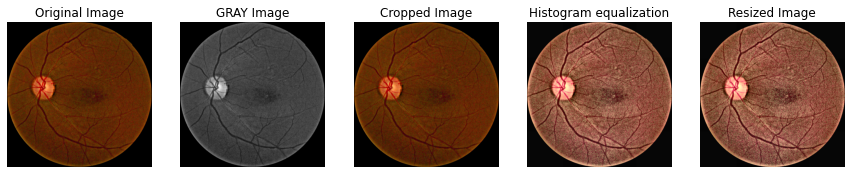

True

In [10]:
import matplotlib.pyplot as plt

def show_images_side_by_side(images, titles):
    # 여러 이미지를 양옆으로 나란히 출력하는 함수
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        axes[i].imshow(images[i], cmap='gray' if len(images[i].shape)==2 else None)
        axes[i].set_title(titles[i])
        axes[i].axis('off')

    plt.show()

# 이미지 전처리 단계별 결과 확인
#image_path = r"D:\VS_Code\DN_project\DR-GeuAl\data\EyePACS\diabetic-retinopathy-detection\train\train\100_right.jpeg"
#image_path = r"D:\VS_Code\DN_project\DR-GeuAl\data\IDRiD\A. Segmentation\A. Segmentation\1. Original Images\a. Training Set\IDRiD_274.jpg"
image_path = "../data/FGADR/Seg-set/Original_Images/1222_1.png"

# 1. 원본 이미지
original_image = cv2.imread(image_path)

# BGR 이미지를 RGB로 변환
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
titles = ["Original Image"]

# 1.5 그레이스케일 이미지
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

titles.append("GRAY Image")

# 2. 모든 측면에서 빈 영역을 자른 이미지
cropped_image = crop_black_borders(original_image_rgb)
titles.append("Cropped Image")

# 3. 대비 향상을 위해 히스토그램 균등화를 적용한 이미지
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
contrast_enhanced_image = apply_clahe(cropped_image, clahe)
titles.append("Histogram equalization")

# 4. 리사이징한 이미지
resized_image = resize_image(contrast_enhanced_image, (512, 512))
titles.append("Resized Image")

# 모든 이미지를 양옆으로 출력
show_images_side_by_side([original_image_rgb, gray_image, cropped_image, contrast_enhanced_image, resized_image], titles)

# 이미지 파일로 저장
cv2.imwrite("../data/test_data/original_image_rgb.png", cv2.cvtColor(original_image_rgb, cv2.COLOR_RGB2BGR))
cv2.imwrite("../data/test_data/gray_image.png", gray_image)
cv2.imwrite("../data/test_data/cropped_image.png", cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))
cv2.imwrite("../data/test_data/contrast_enhanced_image.png", cv2.cvtColor(contrast_enhanced_image, cv2.COLOR_RGB2BGR))
cv2.imwrite("../data/test_data/1222_1.png", cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))

In [ ]:
import os
import cv2
from shutil import copyfile
from tqdm import tqdm

# def find_images_with_small_difference(image_folder, threshold=100):
#     # 이미지 폴더에서 파일 목록 읽기
#     image_files = os.listdir(image_folder)

#     # 차이가 100 미만인 이미지 파일명 찾기
#     small_difference_images = []
#     for image_file in tqdm(image_files, desc="Processing images", unit="image"):
#         original_image_path = os.path.join(image_folder, image_file)
#         original_image = cv2.imread(original_image_path)

#         # crop_black_borders 함수를 사용하여 자른 이미지
#         cropped_image = crop_black_borders(original_image)

#         # 차이가 threshold 미만이고 5 이상인지 확인
#         difference = abs(original_image[0].shape[0] - cropped_image[0].shape[0])
#         if 5 < difference < threshold:
#             small_difference_images.append(original_image_path)

#     return small_difference_images

# def save_images_to_folder(image_folder, output_folder, image_files):
#     # 결과를 저장할 폴더 생성
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)

#     # 이미지를 결과 폴더에 복사
#     for image_file in tqdm(image_files, desc="Saving images", unit="image"):
#         original_image_path = os.path.join(image_folder, image_file)
#         output_image_path = os.path.join(output_folder, image_file)
#         copyfile(original_image_path, output_image_path)

def save_preprocessed_images_to_folder(image_folder, output_folder, exclude_files):
    # 결과를 저장할 폴더 생성
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 이미지 폴더에서 파일 목록 읽기
    image_files = os.listdir(image_folder)

    # small_difference_files에 해당하지 않는 파일만 전처리 및 저장
    for image_file in tqdm(image_files, desc="Processing images", unit="image"):
        if image_file not in exclude_files:
            original_image_path = os.path.join(image_folder, image_file)
            output_image_path = os.path.join(output_folder, image_file)
            
            # Print the file name and shape of the loaded image
            original_image = cv2.imread(original_image_path)

           # 전처리 함수 호출 (정규화를 수행하도록 변경)
            preprocessed_image = preprocess_image(original_image_path)

            # 전처리된 이미지를 결과 폴더에 저장
            cv2.imwrite(output_image_path, preprocessed_image * 255.0)  # 정규화된 이미지를 다시 0~255 범위로 스케일링

# 이미지 폴더에서 차이가 100 미만인 파일명 찾기
image_folder_path = r"D:\VS_Code\DN_project\DR-GeuAl\data\EyePACS\diabetic-retinopathy-detection\train\train"
output_folder_path = r"D:\VS_Code\DN_project\DR-GeuAl\data\EyePACS\diabetic-retinopathy-detection\train\preprocessed"

threshold_value = 200
#small_difference_files = find_images_with_small_difference(image_folder_path, threshold_value)

# small_difference_files에 해당하지 않는 파일들의 전처리 결과를 저장
save_preprocessed_images_to_folder(image_folder_path, output_folder_path, small_difference_files)


In [ ]:
print(len(small_difference_files))
print(small_difference_files)

In [ ]:
image_folder_path = r"D:\VS_Code\DN_project\DR-GeuAl\data\EyePACS\diabetic-retinopathy-detection\train\train"

# 이미지 폴더에서 파일 목록 읽기
image_files = os.listdir(image_folder_path)

# 8700번째 이미지 파일의 이름 출력
if len(image_files) > 21628:
    print(f"8700번째 이미지 파일의 이름: {image_files[21628]}")
else:
    print("이미지 파일이 8700개보다 적습니다.")

In [ ]:
# 차이가 5이상 200미만인 이미지 원본과 전처리 결과 이미지 출력

#image_folder_path = r"D:\VS_Code\DN_project\DR-GeuAl\data\EyePACS\diabetic-retinopathy-detection\train\train"
image_folder_path = r"D:\VS_Code\DN_project\DR-GeuAl\data\EyePACS\diabetic-retinopathy-detection\train\5_200"

for image_file in small_difference_files:
    # 이미지 경로
    image_path = os.path.join(image_folder_path, image_file)

    # 1. 원본 이미지
    original_image = cv2.imread(image_path)
    titles = [f"Original Image - {image_file}"]
    images = [cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)]

    # 2. 최종 이미지
    preprocessed_image = preprocess_image(image_path, img_size=(512, 512))
    titles.append(f"result Image - {image_file}")
    images.append(cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2RGB))

    # 이미지 출력
    plt.figure(figsize=(15, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

In [ ]:
import os
import random
import matplotlib.pyplot as plt

# 이미지 파일이 들어있는 폴더 경로
image_folder_path = r"D:\VS_Code\DN_project\DR-GeuAl\data\EyePACS\diabetic-retinopathy-detection\train\train"
#image_folder_path = r"D:\VS_Code\DN_project\DR-GeuAl\data\EyePACS\diabetic-retinopathy-detection\train\5_200"
#image_folder_path = r"D:\VS_Code\DN_project\DR-GeuAl\data\IDRiD\A. Segmentation\A. Segmentation\1. Original Images\a. Training Set"

# 폴더에서 이미지 파일 리스트 가져오기
image_files = [f for f in os.listdir(image_folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# 무작위로 20개의 이미지 선택
selected_images = random.sample(image_files, 20)

for image_file in selected_images:
    # 이미지 경로
    image_path = os.path.join(image_folder_path, image_file)

    # 1. 원본 이미지
    original_image = cv2.imread(image_path)
    titles = [f"Original Image - {image_file}"]
    images = [cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)]

    # 2. 리사이징한 이미지
    preprocessed_image = preprocess_image(image_path, img_size=(512, 512))
    titles.append(f"Resized Image - {image_file}")
    images.append(cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2RGB))

    # 이미지 출력
    plt.figure(figsize=(15, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.show()


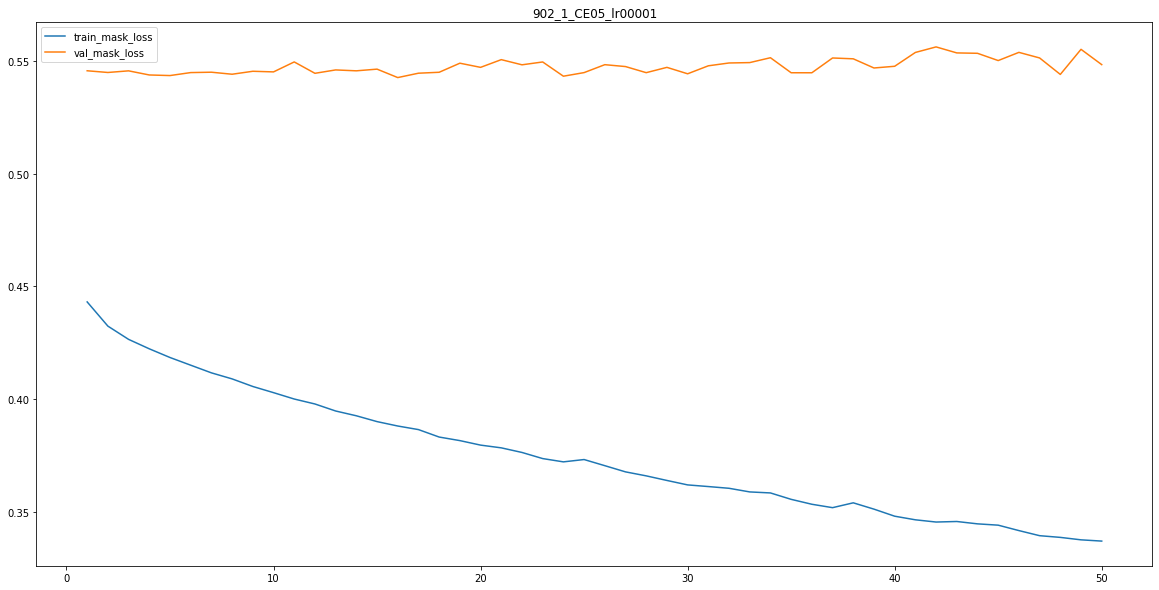

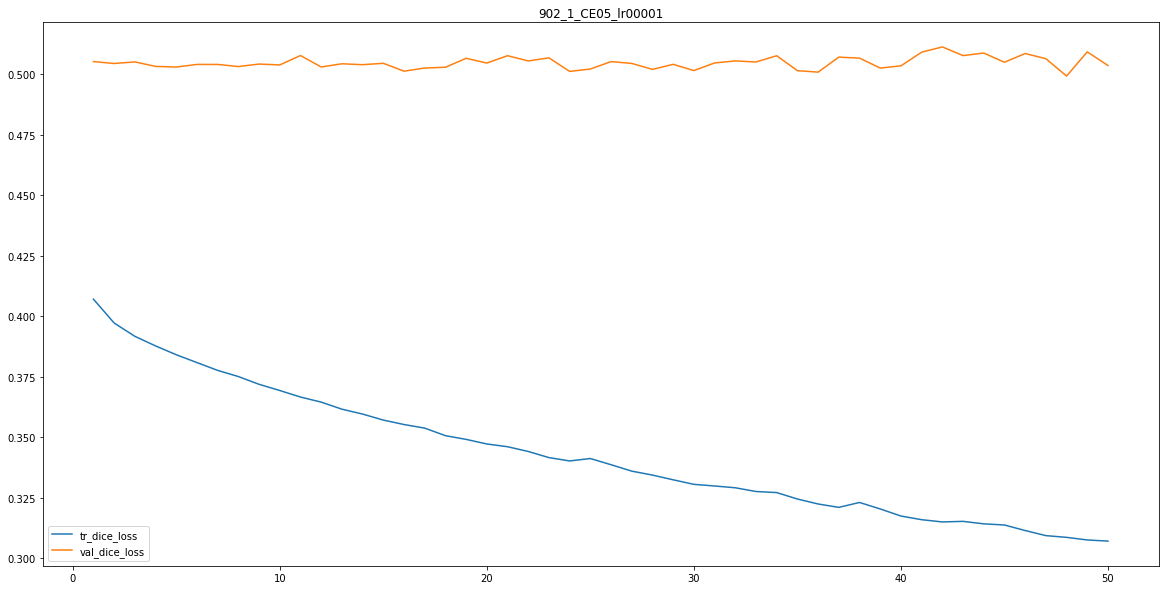

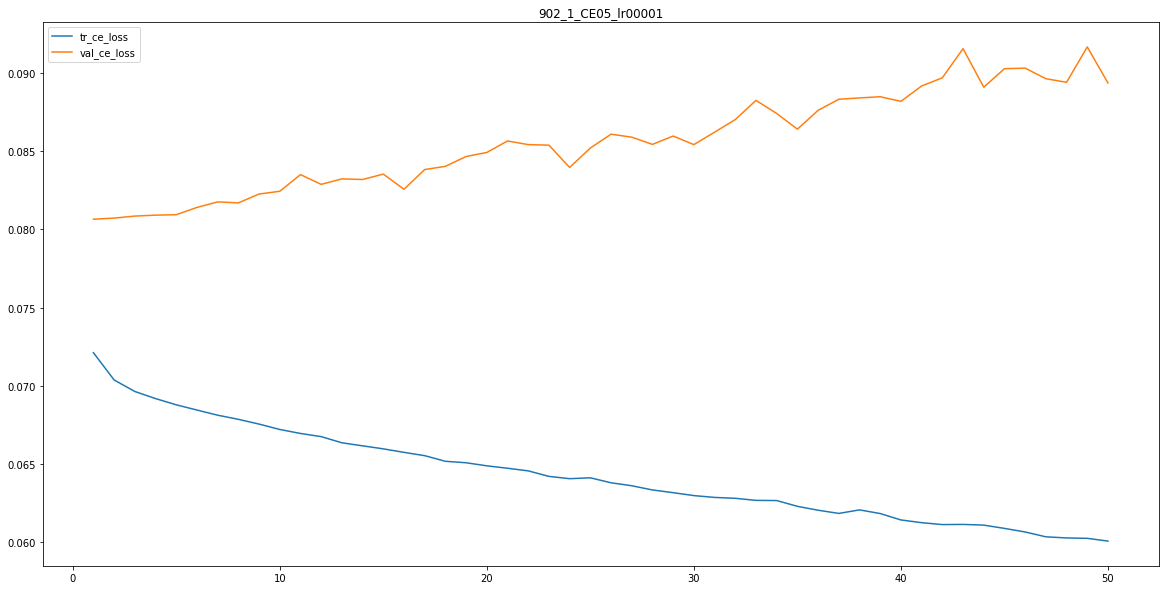

In [5]:
from assets.one_mask.utils import parse_history_text, parse_history_text_CE
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import os

os.listdir('history/one_mask/New')

# history = parse_history_text('history/one_mask/New/9_CLAHE_CE_lr00001.txt')
file_name = '902_1_CE05_lr00001'
history = parse_history_text_CE(f'history/one_mask/New/{file_name}.txt')

plt.figure(figsize=(20, 10))

plt.plot(history['epoch'], history['train_mask_loss'], label='train_mask_loss')
plt.plot(history['epoch'], history['val_mask_loss'], label='val_mask_loss')

plt.title(f'{file_name}')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))

plt.plot(history['epoch'], history['tr_dice_loss'], label='tr_dice_loss')
plt.plot(history['epoch'], history['val_dice_loss'], label='val_dice_loss')

plt.title(f'{file_name}')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))

plt.plot(history['epoch'], history['tr_ce_loss'], label='tr_ce_loss')
plt.plot(history['epoch'], history['val_ce_loss'], label='val_ce_loss')

plt.title(f'{file_name}')
plt.legend()
plt.show()

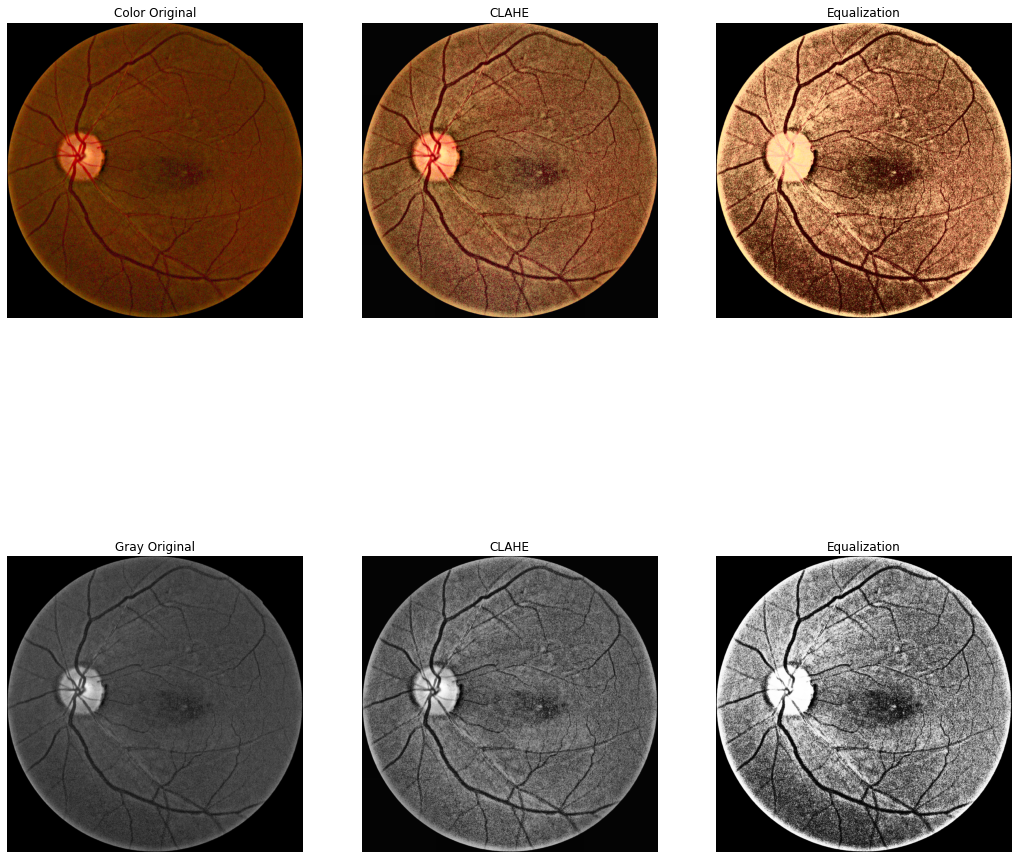

In [6]:
import cv2
import matplotlib.pyplot as plt
from skimage import io


# main function
def histogram_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
    # Color image
    if len(image.shape) == 3:
        ycrcb_array = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        y, cr, cb = cv2.split(ycrcb_array)
        merge_array = cv2.merge([clahe.apply(y), cr, cb])
        output = cv2.cvtColor(merge_array, cv2.COLOR_YCrCb2RGB)
    # Gray image
    else:
        output = clahe.apply(image)
    return output

def histogram_equal(image):
    # Color image
    if len(image.shape) == 3:
        lab_array = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab_array)
        equalized_l = cv2.equalizeHist(l)
        merged_array = cv2.merge([equalized_l, a, b])
        output = cv2.cvtColor(merged_array, cv2.COLOR_LAB2RGB)
    # Gray image
    else:
        output = cv2.equalizeHist(image)
    return output


# Image Load
image = io.imread('../data/FGADR/Seg-set/Original_Images/1222_1.png')
#image = r"../data/FGADR/Seg-set/Original_Images/0000_1.png"

# Clahe
output1 = histogram_clahe(image)
# Equalization
output2 = histogram_equal(image)

# gray image
gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Clahe
output3 = histogram_clahe(gray_img)
# Equalization
output4 = histogram_equal(gray_img)

plt.figure(figsize=(18, 18))
# view
plt.subplot(2,3,1)
plt.title('Color Original')
plt.axis('off')
plt.imshow(image)

plt.subplot(2,3,2)
plt.title('CLAHE')
plt.axis('off')
plt.imshow(output1)

plt.subplot(2,3,3)
plt.title('Equalization')
plt.axis('off')
plt.imshow(output2)

plt.subplot(2,3,4)
plt.title('Gray Original')
plt.axis('off')
plt.imshow(gray_img, cmap='gray')

plt.subplot(2,3,5)
plt.title('CLAHE')
plt.axis('off')
plt.imshow(output3, cmap='gray')

plt.subplot(2,3,6)
plt.title('Equalization')
plt.axis('off')
plt.imshow(output4, cmap='gray')
plt.show()